<a href="https://colab.research.google.com/github/Isaiah-Essien/air_quality_time_series_analysis/blob/main/Isaiah_Essien_air_quality_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [132]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam



In [149]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Exploratory Data Analyses with Explanations**

####  In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.


In [155]:
# Load the datasets
train_data = pd.read_csv('/content/drive/MyDrive/Beijing_Air_Quality_Forecasting/data/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Beijing_Air_Quality_Forecasting/data/test.csv')

In [112]:
#Check what the data looks like
train_data.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [135]:
# Summarize the train and test data
print("Summary of Train Data:")
print(train_data.describe())

print("\nSummary of Test Data:")
print(test_data.describe())

Summary of Train Data:
                 No          DEWP          TEMP          PRES           Iws  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean   15338.500000     -0.029431     -0.062712      0.013612      0.030542   
std     8855.542765      0.994087      1.015193      1.008991      1.018337   
min        1.000000     -2.135153     -2.578070     -2.380821     -0.468688   
25%     7669.750000     -0.888034     -0.938521     -0.822670     -0.441894   
50%    15338.500000     -0.056622      0.045209     -0.043595     -0.352512   
75%    23007.250000      0.913358      0.864984      0.832865      0.005216   
max    30676.000000      1.814055      2.340578      2.877939     11.231956   

                 Is            Ir       cbwd_NW       cbwd_SE       cbwd_cv  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean       0.016992      0.011253      0.016193      0.005833     -0.025008   
std        1.087278      1.0

In [114]:
#Survey the data columns
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB


In [115]:
#Check the mode of the target column and count
mode_value=train_data['pm2.5'].mode()[0]
print(mode_value)

mode_count=train_data['pm2.5'].value_counts()
print(mode_count)

16.0
pm2.5
16.0     462
13.0     407
11.0     402
12.0     386
17.0     385
        ... 
611.0      1
524.0      1
491.0      1
521.0      1
517.0      1
Name: count, Length: 563, dtype: int64


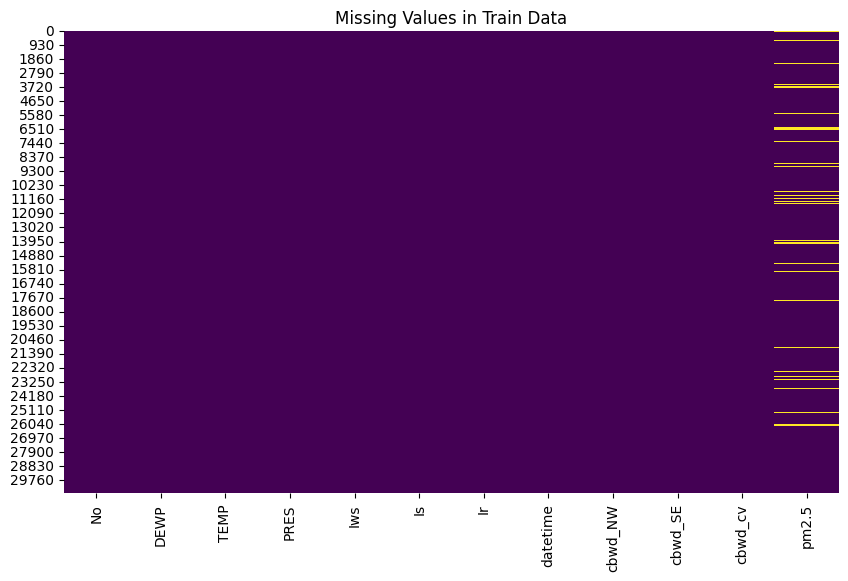

In [116]:
# Check for missing values
missing_values = train_data.isnull().sum()
# Visualizing missing values
plt.figure(figsize=(10, 6))
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Train Data")
plt.show()

## **Key Observation:**

Missing Values:

The pm2.5 column has notable missing values, as seen in the heatmap. These need to be handled carefully since they directly affect the target predictions.
No significant missingness is observed in other columns.

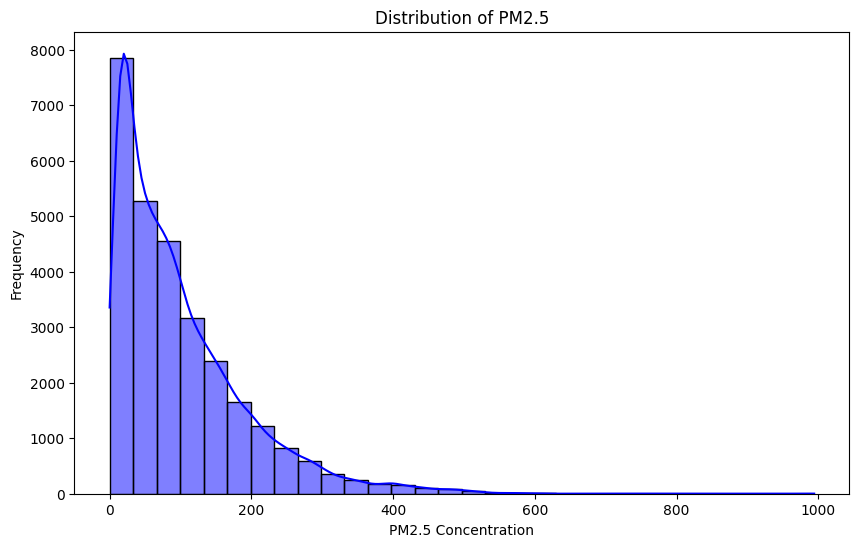

In [117]:
# Distribution of pm2.5
plt.figure(figsize=(10, 6))
sns.histplot(train_data['pm2.5'], kde=True, bins=30, color='blue')
plt.title("Distribution of PM2.5")
plt.xlabel("PM2.5 Concentration")
plt.ylabel("Frequency")
plt.show()

## **Key Observation:**

PM2.5 Distribution:

The distribution of pm2.5 is skewed with a long tail on the right, indicating some extremely high values (outliers). This skewness might affect model performance.

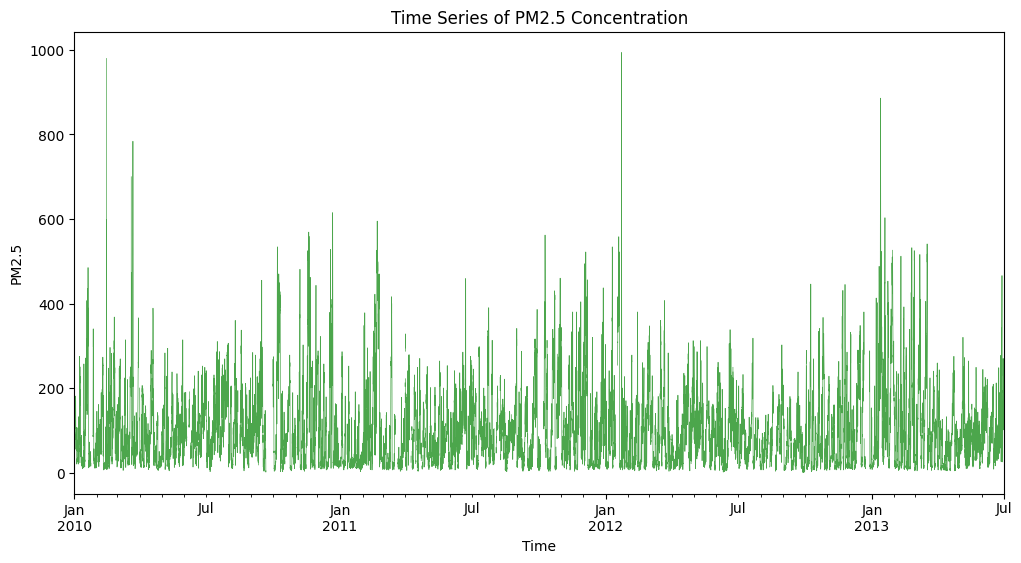

In [118]:
# Convert datetime column to datetime type
train_data['datetime'] = pd.to_datetime(train_data['datetime'])
train_data.set_index('datetime', inplace=True)

# Time-series plot for PM2.5
plt.figure(figsize=(12, 6))
train_data['pm2.5'].plot(linewidth=0.5, color='green', alpha=0.7)
plt.title("Time Series of PM2.5 Concentration")
plt.ylabel("PM2.5")
plt.xlabel("Time")
plt.show()

## **Key Observation:**

Time-Series Trends(pm2.5 concentration):

The time-series plot shows noticeable seasonal trends and fluctuations in pm2.5. There are periods with sharp spikes, possibly due to specific weather events or seasonal factors.

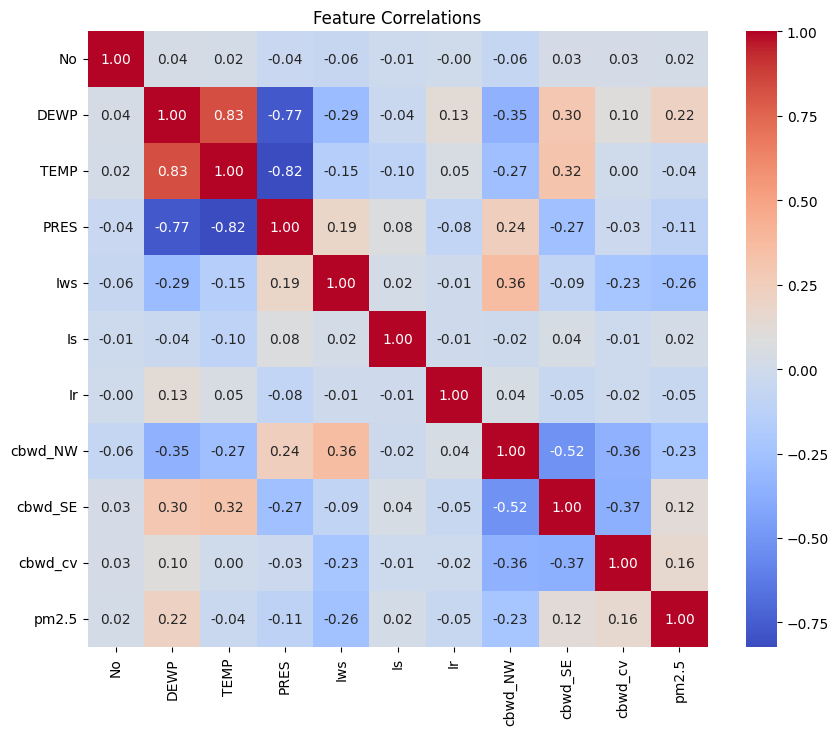

In [119]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = train_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()

## **Key Observation:**

Feature Correlations:

Some features, like TEMP, DEWP, and PRES, show moderate correlations with pm2.5.
The wind-related features (Iws, cbwd_*) seem to have weaker correlations but may still provide useful contextual information.

In [136]:
# Inspecting the first few rows of the dataset to understand its structure.
print(f"Training Data Overview: \n\n {train_data.head()}")

Training Data Overview: 

    No      DEWP      TEMP      PRES       Iws        Is        Ir  \
0   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353 -0.137667   
1   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353 -0.137667   
2   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353 -0.137667   
3   4 -1.580878 -2.168183  0.248559 -0.280926 -0.069353 -0.137667   
4   5 -1.511594 -2.004228  0.151174 -0.218339 -0.069353 -0.137667   

              datetime   cbwd_NW   cbwd_SE   cbwd_cv  pm2.5  
0  2010-01-01 00:00:00  1.448138 -0.732019 -0.522096    NaN  
1  2010-01-01 01:00:00  1.448138 -0.732019 -0.522096    NaN  
2  2010-01-01 02:00:00  1.448138 -0.732019 -0.522096    NaN  
3  2010-01-01 03:00:00  1.448138 -0.732019 -0.522096    NaN  
4  2010-01-01 04:00:00  1.448138 -0.732019 -0.522096    NaN  


In [137]:
#checking the columns
train_data.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [138]:
#check the shape and size of the dataset
train_data.shape

(30676, 12)

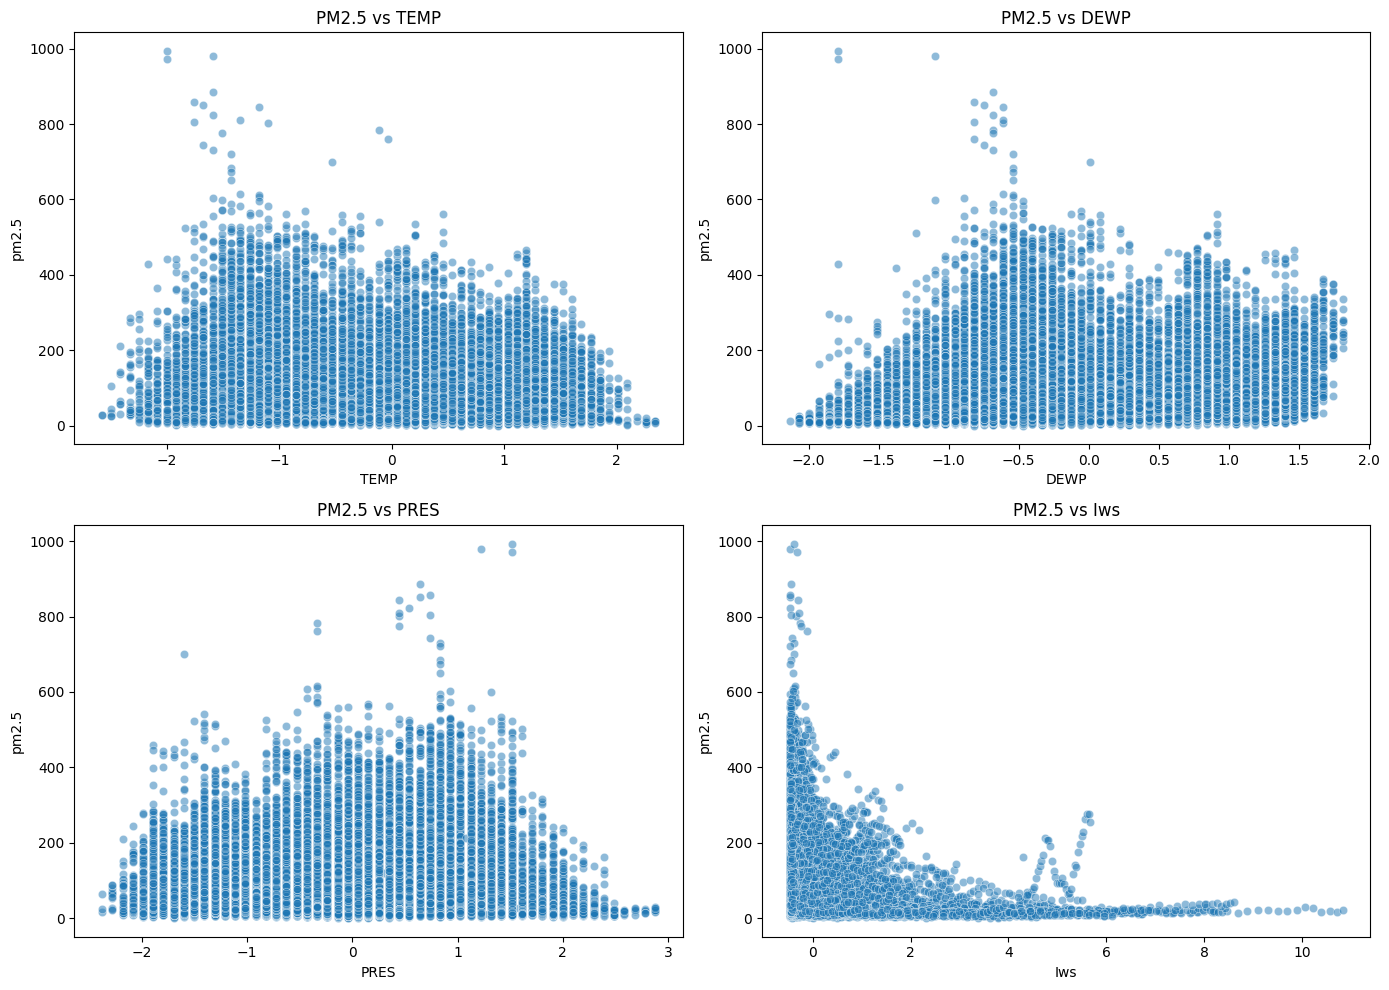

In [139]:
# Scatter plots for key features against pm2.5
features_to_plot = ['TEMP', 'DEWP', 'PRES', 'Iws']

plt.figure(figsize=(14, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data=train_data, x=feature, y='pm2.5', alpha=0.5)
    plt.title(f"PM2.5 vs {feature}")
plt.tight_layout()
plt.show()

## Relationships Between PM2.5 and Features:

Scatter plots show trends and correlations, helping identify strong predictors.

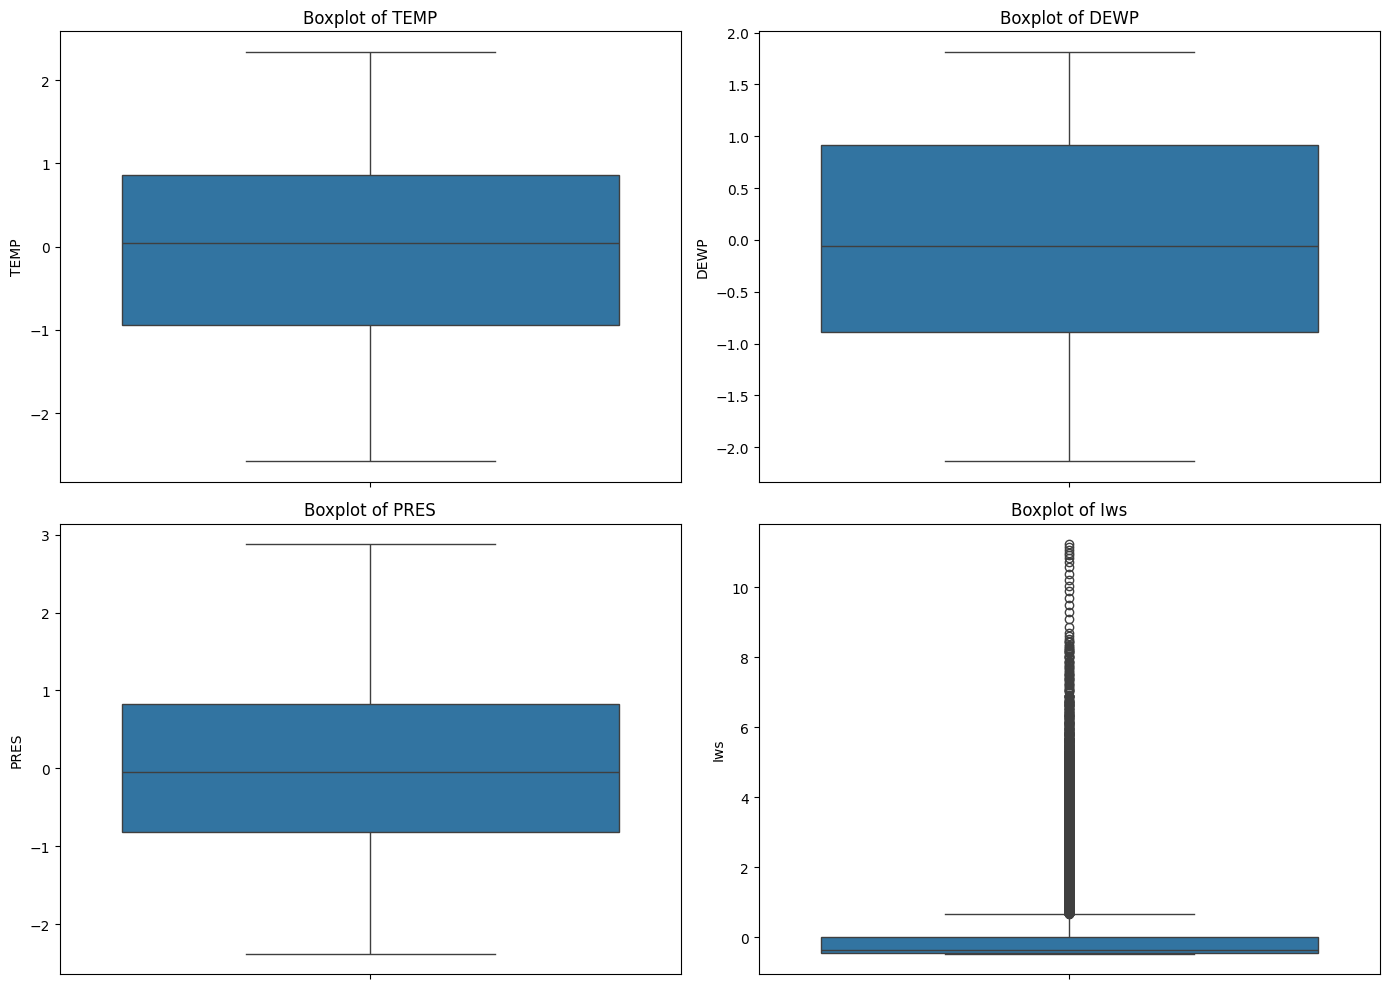

In [140]:
# Boxplots for detecting outliers in key features
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=train_data, y=feature)
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()


## Outlier Detection:

Boxplots highlight extreme values that could skew training.

## Feature Engineering (Time-Based Features):

Extracting hour, day, month, year, etc., captures temporal patterns in the data.
Boxplots of PM2.5 against time-based features reveal seasonal and hourly variations.

# Improve Preprocessing and Feature Engineering


- handle Missing values
- Handle Outliers
- Scale Features
- Finalize Feuture engineering
- Prepare data for LSTM

In [142]:
# check the few rows one more time
train_data.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,129.0
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,129.0
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,129.0
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,129.0
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,129.0


In [156]:
# Ensure 'datetime' column is in datetime format
train_data['datetime'] = pd.to_datetime(train_data['datetime'])

test_data['datetime'] = pd.to_datetime(test_data['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train_data.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test_data.set_index('datetime', inplace=True)


In [157]:
# Fill missing values with bfill and fill
train_data['pm2.5'].fillna(method='bfill', inplace=True)
train_data['pm2.5'].fillna(method='ffill', inplace=True)

<ipython-input-157-922d02c72890>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['pm2.5'].fillna(method='bfill', inplace=True)
<ipython-input-157-922d02c72890>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data['pm2.5'].fillna(method='bfill', inplace=True)
<ipython-input-157-922d02c72890>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.

The updated PM2.5 distribution after clipping looks good, as we can see! The tail of the distribution has been trimmed, reducing the influence of extreme outliers. This should help the model focus more on typical PM2.5 values rather than being overly influenced by rare, extreme values.

In [163]:
# prepare data for training
X_train = train_data.drop(['pm2.5', 'No'], axis=1)
y_train = train_data['pm2.5']
X_train = np.expand_dims(X_train, axis=1)

In [162]:
# # Drop unnecessary columns
# test_data_preprocessed = test_data.drop(['No', 'datetime'], axis=1)

# # Reshape the test data for LSTM input (samples, timesteps, features)
# X_test = test_data_preprocessed.values.reshape((test_data_preprocessed.shape[0], 1, test_data_preprocessed.shape[1]))

# print(f"Preprocessed X_test shape: {X_test.shape}")


# Initial Models without A good Data Exploration:


- This sections outlines the cells with the models trained from the version of the started notebook, accounting for my submission 1-10 on Kaggle
- Most of the cells will be commented

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [ ]:
# define model----------------Initial first model------------
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()



In [ ]:
# -----------------------Define an improved LSTM model 2 for second Model with  two LSTM Layers with 64 neurons and 32 neurons--------------
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model with a tuned optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Tuned learning rate
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    verbose=1
)

In [ ]:
# -------------------Model 3 with Updated parameters and early stopping------------------

# Define an improved LSTM model with batch normalization and early stopping
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),  # Normalize after the first LSTM layer
    Dropout(0.3),
    LSTM(64, activation='relu', return_sequences=False),
    BatchNormalization(),  # Normalize after the second LSTM layer
    Dropout(0.3),
    Dense(1)  # Output layer
])

# Compile the model with tuned optimizer and RMSE as a custom metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Reduced learning rate for stability
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)


# Print the model summary
model.summary()

# Add early stopping to your training call when fitting the model:
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping])
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    verbose=1,
)


In [ ]:
#-----------------Model 4 with 3 layers with Tanh in the first two layers and relu in the last-----------------------
# Define an enhanced LSTM model
model = Sequential([
    # First LSTM Layer with 128 neurons and return_sequences=True
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.25),

    # Second LSTM Layer with 64 neurons
    LSTM(64, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    # Third LSTM Layer with 32 neurons, no return_sequences
    LSTM(32, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    # Output Layer
    Dense(1)
])

# Compile the model with a refined optimizer and RMSE as a custom metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),  # Further reduced learning rate
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,  # Restore the best weights when training stops
    verbose=1
)

# Print the model summary
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)


In [ ]:
# -------------------Model 5 with Updated parameters, imrpved from model three------------------

# Define an improved LSTM model with batch normalization and early stopping
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),  # Normalize after the first LSTM layer
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=False),
    BatchNormalization(),  # Normalize after the second LSTM layer
    Dropout(0.4),
    Dense(1)  # Output layer
])

# Compile the model with tuned optimizer and RMSE as a custom metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),  # Reduced learning rate for stability
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)


# Print the model summary
model.summary()

# Add early stopping to your training call when fitting the model:
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping])
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
)


In [ ]:
# -------------------Model 6 with Updated parameters, using L2 Regularizer------------------

# Define an improved LSTM model with L2 regularization and batch normalization
model = Sequential([
    LSTM(128,
         activation='relu',
         return_sequences=True,
         input_shape=(X_train.shape[1], X_train.shape[2]),
         kernel_regularizer=l2(0.01)),  # L2 regularization added
    BatchNormalization(),  # Normalize after the first LSTM layer

    LSTM(64,
         activation='relu',
         return_sequences=False,
         kernel_regularizer=l2(0.01)),  # L2 regularization added
    BatchNormalization(),  # Normalize after the second LSTM layer

    Dense(1, kernel_regularizer=l2(0.01))  # Output layer with L2 regularization
])

# Compile the model with tuned optimizer and RMSE as a custom metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),  # Reduced learning rate for stability
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Print the model summary
model.summary()

# Fit the model with the same parameters
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    verbose=1,
)


# Experiment with Regularization and Validation Techniques on the preprocessed train_data

In this step, I focus on designing and training a robust LSTM model by incorporating regularization techniques and implementing proper validation strategies to prevent overfitting.

**Experiment with Regularization and Validation Techniques:**
- Include dropout layers to reduce overfitting.
- Add batch normalization for stable training.
- Use L2 regularization on weights.

**Implement a validation strategy:**
- Use time-series validation to ensure proper temporal splits.

**Optimize model trainig:**
- Use early stopping to prevent overfitting.
- Experiment with different optimizers and learning rates.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                       │ (None, 1, 128)              │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 1, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 1, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 1, 32)               │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ (None, 1, 16)               │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 1, 16)               │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 1, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1, 1)                │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,593 (533.57 KB)

 Trainable params: 136,113 (531.69 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - lambda: 132.5915 - loss: 17971.0449
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - lambda: 120.8007 - loss: 12672.6084
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - lambda: 109.6279 - loss: 8093.5698
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - lambda: 106.4622 - loss: 6914.1772
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - lambda: 104.7060 - loss: 6537.2134
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - lambda: 105.1829 - loss: 6540.3955
Epoch 7/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - lambda: 104.0896 - loss: 6465.3110
Epoch 8/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - lambda: 106.0318 - loss: 6621.0522
Epoch 9/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - lambda: 106.0029 - loss: 6786.6138
Epoch 10/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - lambda: 105.6533 - loss: 6638.4731
Epoch 11/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - lambda: 104.9659 - loss: 6588.

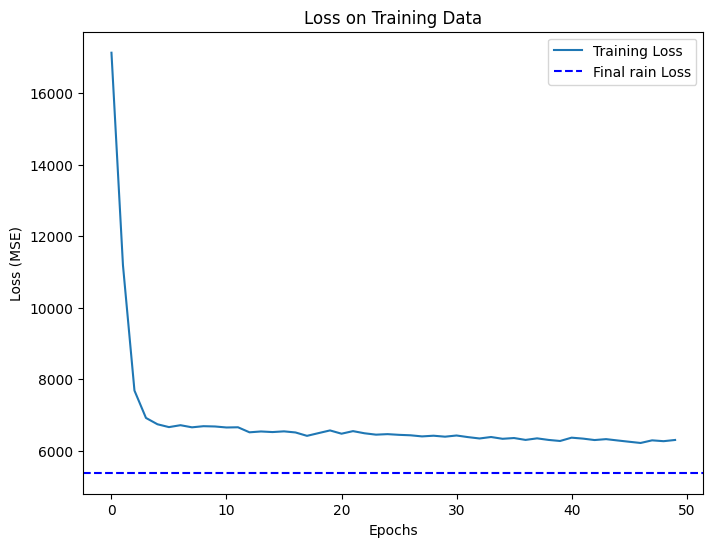

Final Training Loss (MSE): 5381.599079763964


In [180]:
# Define the model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]),
          return_sequences=True),
    Dropout(0.6),  # Dropout layer to reduce overfitting
    BatchNormalization(),  # Batch normalization for stable training

    LSTM(64, activation='relu',return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),

    LSTM(32, activation='relu',return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),

    LSTM(16, activation='relu',return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1)  # Final layer for regression
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0008),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))] # RMSE metric

    )
# Model summary
model.summary()


# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
)


# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [181]:
# Prepare the test data
X_test = test_data.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test_data.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Beijing_Air_Quality_Forecasting/submission_test.csv', index=False)

print(f"Submission file saved to {submission}")


411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Submission file saved to                     row ID  pm2.5
6      2013-07-02 10:00:00     36
7      2013-07-02 11:00:00     34
8      2013-07-02 12:00:00     31
9      2013-07-02 13:00:00     29
10     2013-07-02 14:00:00     29
...                    ...    ...
13129   2014-12-31 5:00:00     26
13130   2014-12-31 6:00:00     24
13131   2014-12-31 7:00:00     25
13132   2014-12-31 8:00:00     25
13133   2014-12-31 9:00:00     24

[13148 rows x 2 columns]


0
